In [1]:
using DataFrames
using Chemfiles
using Plots, LaTeXStrings
home = "/home/german/labo/18/lbp/run"
rtdos = "/home/german/labo/18/lbp/rtdos_log"

"/home/german/labo/18/lbp/rtdos_log"

In [2]:
# Agarra una matriz de PCA en Calpha de 3Nx3N-6 y devuelve
# una lista de 3N-6 matrices, c/u de 3x3N. C/ mtx es 1 modo reordenado
# p/ matchear las matrices de coordenadas de carbonos alfa
function format_pca_aa(in_mtx::Array{Float64, 2})
    v_length = size(in_mtx)[1]
    v_nbr = size(in_mtx)[2]

    aa = Int64
    try
        aa = convert(Int64, v_length / 3)
    catch
        error("Vector length: ", v_length, " is not divisible by 3.")
    end

    list_out_mtx = Array{Array{Float64, 2}, 1}(v_nbr);
    for j = 1:v_nbr
        list_out_mtx[j] = reshape(in_mtx[:, j], 3, aa)
    end

    return list_out_mtx
end


# Agarra la topología una matriz de PCA en Calpha de 3Nx3N-6 y devuelve
# una lista de 3N-6 matrices, c/u de 3xNatomos. C/ mtx es 1 modo reordenado
# p/ matchear las matrices de coordenadas del pdb q dió lugar a la topología.

# También devuelve un array con el nro de atomos q tiene c/ aa
function format_pca_atom(in_top::Topology, in_mtx::Array{Float64, 2}, mask::Array{Float64, 1} = 0)
    # Preparo variables
    aa = Int64
    aa_3 = Int64
    if mask == 0 
        aa = convert(Int64, count_residues(in_top))
    else
        aa = length(mask)
    end
    aa_3 = aa * 3
    
    v_length = size(in_mtx)[1]
    v_nbr = size(in_mtx)[2]
    if v_length != aa_3
        error("Input vector with wrong dimensions: ", v_length, "  ", (aa_3, 1))
    end

    # Determino orden de residuos (hay q actualizar el Julia Chemfiles)
    tmp = Array{Int64}(aa)
    ids = Array{Int64}(aa)
    [ ids[i+1] = convert(Int64, id((Residue(in_top, i)))) for i = 0:aa-1 ]
    idx = sortperm(ids)
    # Determino el nro de atomos de c/ aminoácido. Resto 1 pq Chemfiles tiene 0-indexing
    [ tmp[i] = size(Residue(in_top, mask[i] - 1)) for i = 1:aa ]
    natom_aa = tmp[idx]
    natoms = sum(natom_aa)

    # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    list_out_mtx = Array{Array{Float64, 2}, 1}(v_nbr);
    
    for j in 1:v_nbr
        vector = reshape(in_mtx[:, j], 3, aa)
        list_out_mtx[j] = Array{Float64}(3, natoms)
        cursor = 0
        for i = 1:aa
            rango = Array{Int64}(natom_aa[i])
            if i == 1
                list_out_mtx[j][:, 1:natom_aa[i]] = repmat(vector[:, i], 1, natom_aa[i])
                cursor = natom_aa[i]
                continue
            end
            rango = collect(cursor+1:cursor + natom_aa[i])
            list_out_mtx[j][:, rango] = repmat(vector[:, i], 1, natom_aa[i])
            cursor += natom_aa[i]
        end
    end

    return list_out_mtx, natom_aa
end

format_pca_atom (generic function with 2 methods)

In [3]:
function get_κ(in_vec::Array{Float64, 1})
    not_null = copy(in_vec)
    not_null[not_null .== 0] = 0.000001
    const κ = (exp.(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log.(x.^2), not_null, 1), 1))
        / length(not_null))[1]
    return κ
end

function get_pnum(in_vec::Array{Float64, 1})
    nor_vec = in_vec ./ norm(in_vec) 
    return convert(Int64, round(sum(nor_vec .^ 4) .^ -1))
end

function tognm(vtor_anm)
    vtor_gnm = Array{Float64}
    try
        vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    catch e
        warn("Input vector's length is not a 3 multiplier")
        error(e)
    end
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

function WeightedHist(in_vec, in_bins, in_weight, density = false, include_bounds = true)
    # Safety check    
    if length(in_vec) != length(in_weight)
        error("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    if include_bounds
        for i=1:length(in_bins)-1
            if i == 1
                # Include those that fall before the beggining of the bins
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .<= in_bins[i])
                out_counts[i] = sum(in_weight[temp_bool])
            elseif i == length(in_bins)-1
                # Include those that fall after the end of the bins
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .>= in_bins[end])
                out_counts[i] = sum(in_weight[temp_bool])
            else
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
                out_counts[i] = sum(in_weight[temp_bool])
            end
        end
    else
        for i=1:length(in_bins)-1
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
            out_counts[i] = sum(in_weight[temp_bool])
        end
    end
    
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

function MatHisInd2D(in_vec_x::AbstractArray, in_vec_y::AbstractArray,
    in_bins_x::AbstractArray, in_bins_y::AbstractArray,
    include_bounds = true)

    const cnt = length(in_vec_x)
    if  length(in_vec_y) != cnt
        error("Input vectors length don't match. X: ", in_vec_x, " Y: ", in_vec_y)
    end
         
    const n_x = length(in_bins_x)
    const n_y = length(in_bins_y)
    
    his_ind = [Int[] for i=1:n_x, j=1:n_y]
    his = zeros(Int64, n_x, n_y)
    if include_bounds
        for i in 1:cnt
            x = searchsortedfirst(in_bins_x, in_vec_x[i])
            y = searchsortedfirst(in_bins_y, in_vec_y[i])
            if x > n_x
                x = n_x
            end
            if y > n_y
                y = n_y
            end
            
            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    else
        for i in 1:cnt
            const x = searchsortedfirst(in_bins_x, in_vec_x[i])
            const y = searchsortedfirst(in_bins_y, in_vec_y[i])
        
            if x > n_x || y > n_y
                continue
            end
            if (x == 1 && isless(x, in_vec_x[x])) || (y == 1 && isless(y, in_vec_y[y]))
                continue
            end

            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    end
    
    return his_ind, his
end

function read_ptraj_modes(filename, nmodes::Int64=0, norma::Bool=true)
    modes_text = readdlm(filename, skipstart=0, skipblanks=true, comments=true,
        comment_char='\*')

    if nmodes == 0
        nmodes = modes_text[1, 5]
    end
    modes_elements = modes_text[2, 1]

    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)

    eval = Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1 = Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header
    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = permutedims(modes_text[(j+1):(lines+j), :], [2, 1])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
        mode[:, i] = temp2
        j = j + lines + 1
    end

    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end

    return mode, eval
end

function energia_gdte(evals::Array{Float64, 1}, gdte::Array{Float64, 1}, d::Float64 = 1.)

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    const k = 1.38064852e-23
    const avgdro = 6.0221409e+23
    const T = 298
    const RT =  k * avgdro * T * 1E-3 * 0.239006 # Kcal/mol
    const cte = 11792.08316093831
    
    return d^2 * 0.5 * RT * sum(evals.^2 .* gdte.^2) / cte # Kcal/mol
end

energia_gdte (generic function with 2 methods)

### Lee modos, volumen original y  volúmenes NDD. Obtiene VGV

In [23]:
pdb = "1ure"
# Leo modos
modes_1ure, evals_1ure = read_ptraj_modes(joinpath(home, pdb,  "pca", string("full_modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_1ure))
aa = convert(Int64,aa3 / 3)

# Leo volúmenes originales
vol_avg_1ure = convert(Float64, readdlm(joinpath(home, pdb,  "ndd", string("vol_avg_", pdb)))[3])

# Leo volúmenes NDD
ndd_out_1ure = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb,  "ndd", string("out_ndd_", pdb)))[2:end, 2])

# VGV
vgv_1ure = eval(:(ndd_out_1ure .- vol_avg_1ure))
vgv_1ure = vgv_1ure ./ norm(vgv_1ure);

### Obtiene los aa's del hueco

In [26]:
# VGV cartesiano
xyz_vgv_1ure = tognm(modes_1ure * vgv_1ure)

# Pnumber aminoácidos según VGV (aminoácidos de la pared)
cut_1ure = get_pnum(xyz_vgv_1ure)

# Índices de pnumber aminoácidos
idx_cut_1ure = sort(sortperm(abs.(xyz_vgv_1ure), rev = true)[1:cut_1ure])

# Índices de pnumber aminoácidos en 3aa coordenadas
idx_cut_1ure_3 = Array{Int64}(length(idx_cut_1ure) * 3)
for i = 1:length(idx_cut_1ure)
    idx_cut_1ure_3[3*i-2] = idx_cut_1ure[i] * 3 - 2
    idx_cut_1ure_3[3*i-1] = idx_cut_1ure[i] * 3 - 1
    idx_cut_1ure_3[3*i] = idx_cut_1ure[i] * 3
end

### Obtiene los pnum modos y pnum eigenvals. Cut y enteros

In [27]:
# Pnumber de VGV
vgv_pnu_1ure = get_pnum(vgv_1ure)

# Pnumber indices
idx_vgv_pnu_1ure = sortperm(abs.(vgv_1ure), rev=true)[1:vgv_pnu_1ure]

# Pnumber modes
modes_pnu_1ure = modes_1ure[:, idx_vgv_pnu_1ure]

# Pnumber eigenvalues
evals_pnu_1ure = evals_1ure[idx_vgv_pnu_1ure];

# Todos los modos recortados según pnumber aminoácidos y normalizo
modes_cut_1ure = modes_1ure[idx_cut_1ure_3, :]
modes_cut_1ure = mapslices(x -> x ./ norm(x), modes_cut_1ure, 1)

# Pnum modos recortados según pnumber aminoácidos y normalizo
modes_pnu_cut_1ure = modes_pnu_1ure[idx_cut_1ure_3, :]
modes_pnu_cut_1ure = mapslices(x -> x ./ norm(x), modes_pnu_cut_1ure, 1);

### κ

In [28]:
# Colectividad de modos enteros
tmp = eval(:(mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_1ure, 1), 1)))
κ_modes_1ure = reshape(tmp, length(tmp))

# Colectividad de pnum modos enteros
tmp = eval(:(mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_pnu_1ure, 1), 1)))
κ_modes_pnu_1ure  = reshape(tmp, length(tmp))

# Colectividad de modos recortados
tmp = mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_cut_1ure, 1), 1)
κ_modes_cut_1ure  = reshape(tmp, length(tmp))

# Colectividad de pnum modos recortados
tmp = mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_pnu_cut_1ure, 1), 1)
κ_modes_pnu_cut_1ure = reshape(tmp, length(tmp));

### Pnumber

In [29]:
# Pnumber de modos enteros
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_1ure, 1), 1)
col_modes_1ure = reshape(tmp, length(tmp)) ./ aa

# Pnumber de pnum modos enteros
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_pnu_1ure, 1), 1)
col_modes_pnu_1ure = reshape(tmp, length(tmp)) ./ aa

# Pnumber de modos cut
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_cut_1ure, 1), 1)
col_modes_cut_1ure = reshape(tmp, length(tmp))  ./ cut_1ure

# Pnumber de pnum modos cut
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_pnu_cut_1ure, 1), 1)
col_modes_pnu_cut_1ure = reshape(tmp, length(tmp))  ./ cut_1ure;

# Frecuencia

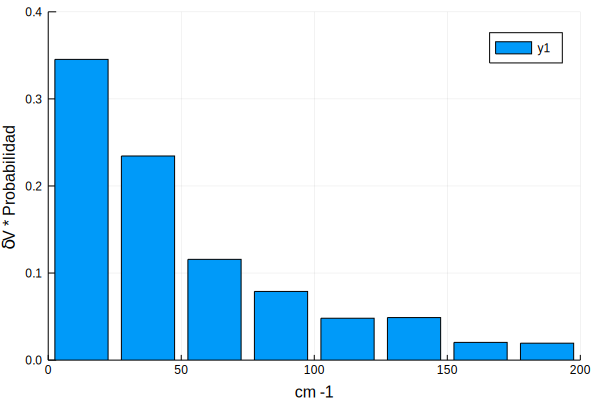

In [99]:
# Los bins van de 0 a la fqcia más alta + 10%
top_evals = maximum(evals_1ure)
bins_evals = collect(0:25:400)

# Histograma ponderado
Whis_evals_1ure, Wbins_evals_1ure = WeightedHist(evals_1ure, bins_evals, abs.(vgv_1ure), true);

bar(Wbins_evals_1ure, Whis_evals_1ure,
    xlims = (0, 200), ylims = (0, .4),
    yaxis = "\\deltaV * Probabilidad", xaxis = "cm -1")

# Colectividad

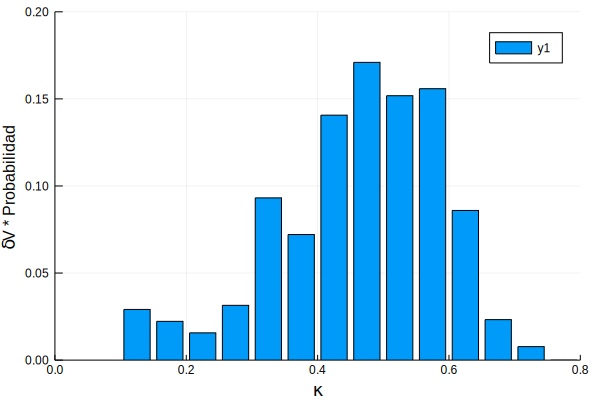

In [108]:
# Los bins van de 0 a la fqcia más alta + 10%
top_κ = maximum(κ_modes_1ure)
bins_κ = collect(0.1:.05:.8)

# Histograma ponderado
Whis_κ_1ure, Wbins_κ_1ure = WeightedHist(κ_modes_1ure, bins_κ, abs.(vgv_1ure), true);

bar(Wbins_κ_1ure, Whis_κ_1ure,
    xlims = (0, .8), ylims = (0, .2),
    yaxis = "\\deltaV * Probabilidad", xaxis = "\\kappa")

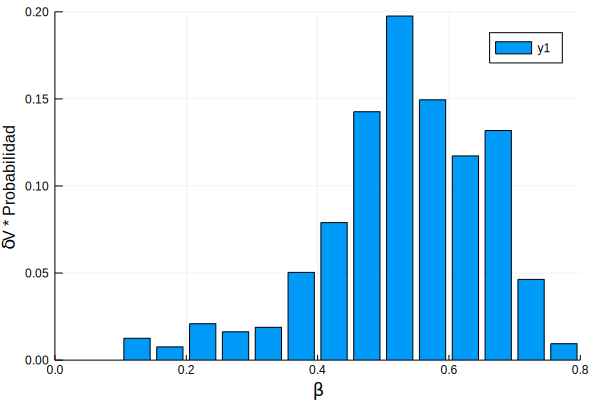

In [107]:
# Histograma ponderado
Whis_κ_cut_1ure, Wbins_κ_cut_1ure = WeightedHist(κ_modes_cut_1ure, bins_κ, abs.(vgv_1ure), true);

bar(Wbins_κ_cut_1ure, Whis_κ_cut_1ure,
    xlims = (0, .8), ylims = (0, .2),
    yaxis = "\\deltaV * Probabilidad", xaxis = "\\beta")

## Colectividad en pnumber

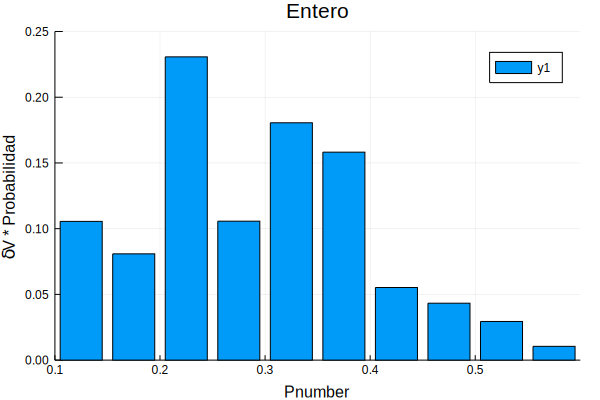

In [113]:
# Los bins van de 0 a la fqcia más alta + 10%
top_col = maximum(col_modes_1ure)
bins_col = collect(0.1:.05:.6)

# Histograma ponderado
Whis_col_1ure, Wbins_col_1ure = WeightedHist(col_modes_1ure, bins_col, abs.(vgv_1ure), true);

bar(Wbins_col_1ure, Whis_col_1ure,
    xlims = (0.1, .6), ylims = (0, .25),
    yaxis = "\\deltaV * Probabilidad", xaxis = "Pnumber", title = "Entero")

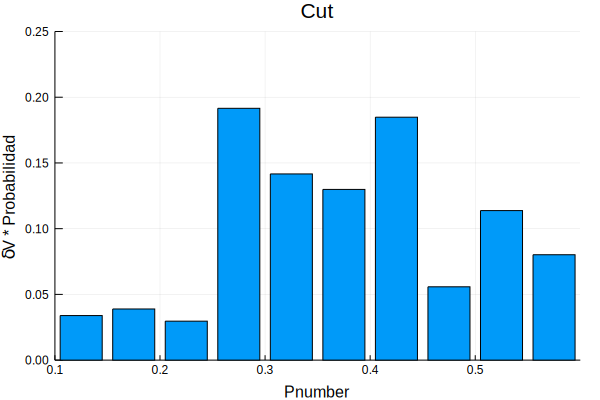

In [118]:
# Los bins van de 0 a la fqcia más alta + 10%
top_col = maximum(col_modes_1ure)
bins_col = collect(0.1:.05:.6)

# Histograma ponderado
Whis_col_cut_1ure, Wbins_col_cut_1ure = WeightedHist(col_modes_cut_1ure, bins_col,
    abs.(vgv_1ure), true);

bar(Wbins_col_cut_1ure, Whis_col_cut_1ure,
    xlims = (0.1, .6), ylims = (0, .25),
    yaxis = "\\deltaV * Probabilidad", xaxis = "Pnumber", title = "Cut",
    legend = false)

## AAs de la pared

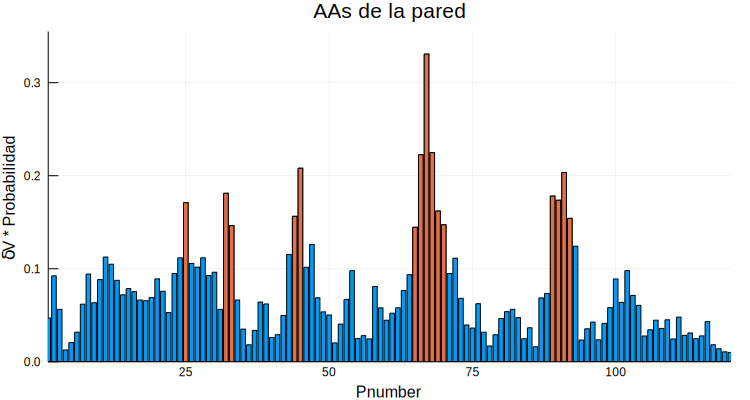

In [146]:
tmp = abs.(xyz_vgv_1ure)
tmp_ = copy(tmp)
tmp_[tmp_ .< .13] .= 0.;

bar(tmp,
    xlims = (1, 120), ylims = (0, .355),
    yaxis = "\\deltaV * Probabilidad", xaxis = "Pnumber", title = "AAs de la pared",
    legend = false, size = (750, 400))
bar!(tmp_)

## Volumen de la trayectoria

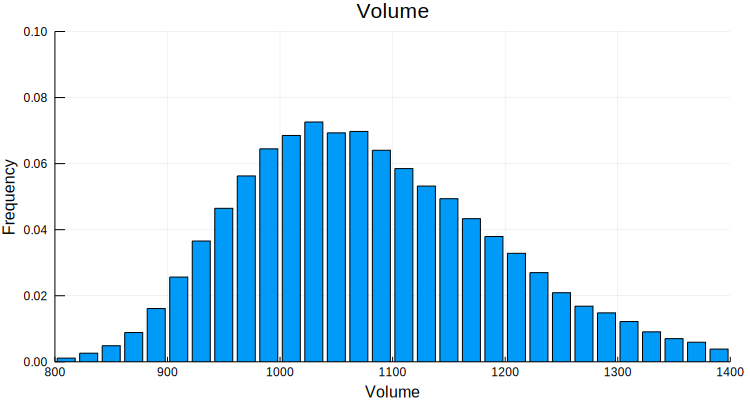

In [155]:
trj_vol = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);

bin_vol = collect(800:20:1400)
wgh_vol = fill(1.0, length(trj_vol))

# Histograma ponderado
Whis_vol_1ure, Wbins_vol_1ure = WeightedHist(trj_vol, bin_vol, wgh_vol, true, false);

bar(Wbins_vol_1ure, Whis_vol_1ure,
    xlims = (800, 1400), ylims = (0, .1),
    yaxis = "Frequency", xaxis = "Volume", title = "Volume",
    legend = false, size = (750, 400))

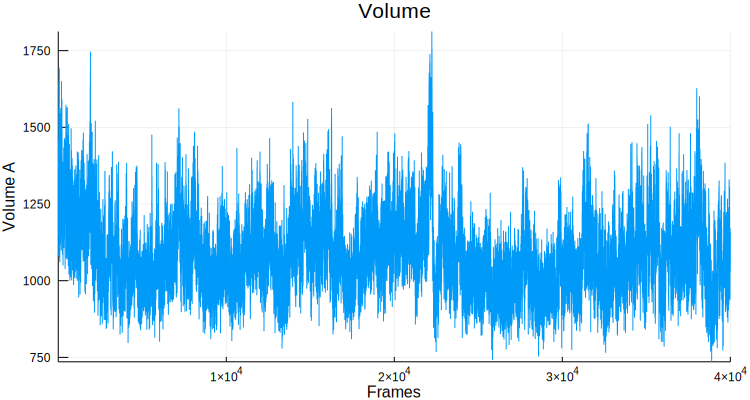

In [159]:
plot(trj_vol,
    yaxis = "Volume A", xaxis = "Frames", title = "Volume",
    legend = false, size = (750, 400))

In [160]:
[ mean(trj_vol) ; std(trj_vol) ]

2-element Array{Float64,1}:
 1083.31 
  120.022

In [ ]:
const c1 = 2114
const cg = 2131

In [33]:
in_trj = Trajectory(joinpath(home, pdb, string("data/full_fit_", pdb, ".nc")))
# High volume 
trj_lig_dis = Array{Float64, 1}(nsteps(in_trj))
for i = 0:nsteps(in_trj)-1
    in_frm = read_step(in_trj, i)
    trj_lig_dis[i+1] = norm(positions(in_frm)[:, c1] - positions(in_frm)[:, cg])
end
close(in_trj)

## LIG

In [38]:
# Distancia entre C1 y CG
df_trj_lig_dis = DataFrame(Distancia = trj_lig_dis, Time = collect(1:length(trj_lig_dis)));

smooth_trj_lig_dis = [ mean(trj_lig_dis[i:i+10]) for i = 1:10:length(trj_lig_dis)-10 ]
push!(smooth_trj_lig_dis, trj_lig_dis[end])
df_smooth_trj_lig_dis = DataFrame(Distancia = smooth_trj_lig_dis,
    Time = collect(1:length(smooth_trj_lig_dis)));

In [39]:
pdf_trj_lig_asa = plot(df_trj_lig_asa, x = "Time", y = "ASA",
    Geom.line, 
    #Geom.smooth(method=:loess,smoothing=0.001),
    Guide.title("ASA lig"),

    Coord.cartesian(xmin = 0, xmax = 5000, ymin = 400, ymax = 550),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

LoadError: [91mUndefVarError: df_trj_lig_asa not defined[39m

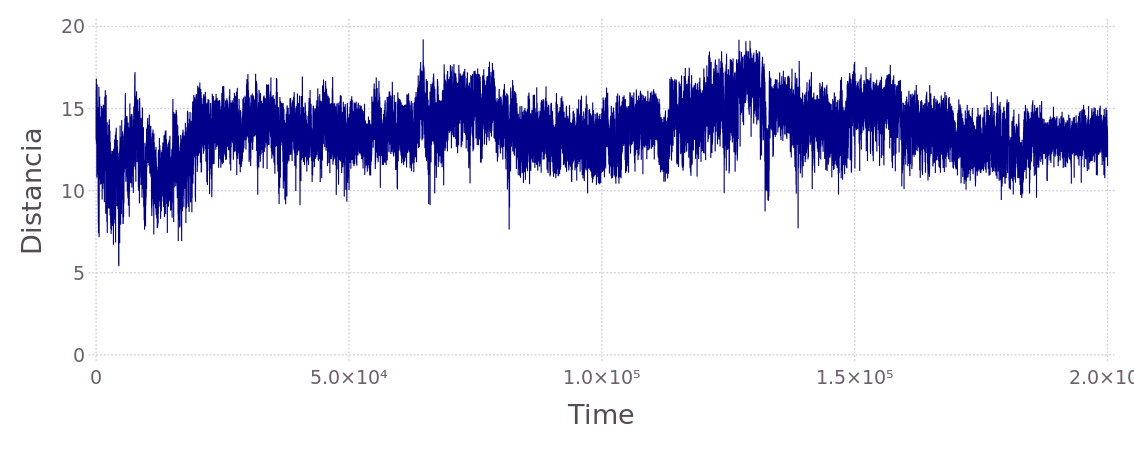

In [48]:
pdf_trj_lig_dis = plot(df_trj_lig_dis, x = "Time", y = "Distancia",
    Geom.line, 
    #Geom.smooth(method=:loess,smoothing=0.001),
    #Guide.title("Cut"),

    #Coord.cartesian(xmin = 0, xmax = 2000, ymin = 400, ymax = 550),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

# Energía

In [50]:
points = 21
maxi = floor(points / 2)
mini = -maxi
RT = 0.693

E_1ure = Array{Float64,1}(points)
i = 0
for d = mini:maxi
    i+=1
    E_1ure[i] = energia_gdte(evals_1ure, vgv_1ure, d * 5E-1)
end

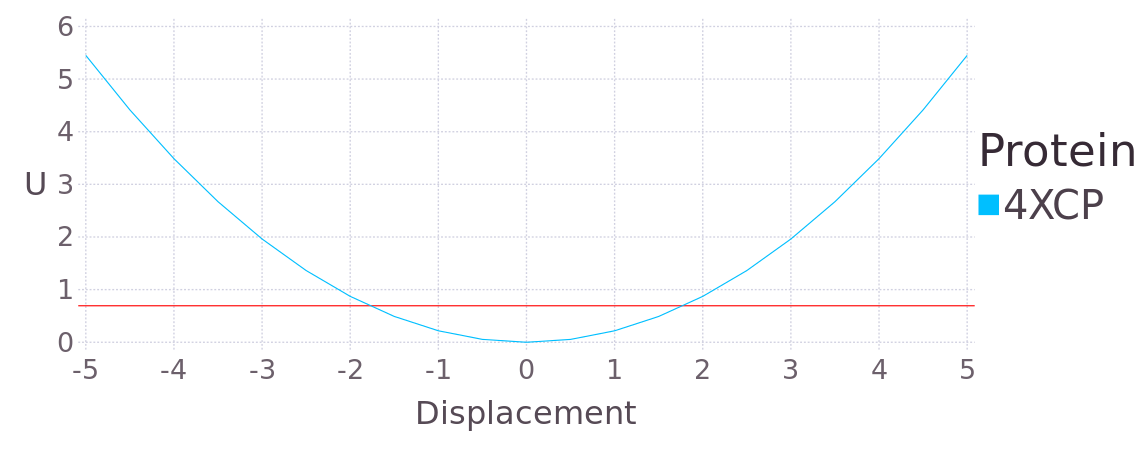

In [51]:
# Compilo en un dataframe.
df_E = DataFrame(U = E_1ure,
    Displacement = repeat(collect(mini:1:maxi) * 5E-1, outer = [1]), 
    Protein = fill("4XCP", points))

pdf_E = plot(df_E, y = "U", x = "Displacement", color = "Protein", Geom.line,
    yintercept = [RT], Geom.hline(color = "red"),
    Guide.xticks(ticks = collect(mini:2:maxi) * 5e-1),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
        minor_label_font_size = 20pt, major_label_font_size = 24pt, key_title_font_size = 34pt,
        key_label_font_size = 30pt))

## Ajuste de volumen a 1 gaussiana

In [53]:
gg = GMM(1, 1)
gg.μ[1, 1] = 550. 
gg.Σ[1, 1] = 100
em!(gg, reshape(trj_vol, length(trj_vol), 1), nIter = 30);

In [59]:
lf_normal = Normal(gg.μ[1], sqrt(gg.Σ[1]))
lf_sampl = rand(lf_normal, 1000000)

bin_nor = collect(300:20:900)
wgh_nor = fill(1.0, length(lf_sampl))

# Histograma ponderado
his_nor_lf, bin_nor_lf = WeightedHist(lf_sampl, bin_nor, wgh_nor, true, false);
df_his_nor_lf = DataFrame(Probability = his_nor_lf .* 0.4, Volume = bin_nor_lf)
    
df_his_nor = DataFrame(Probability = his_nor_lf,
    Volume = bin_nor_lf,
    Conformer = repeat(["LV"], inner = length(his_nor_lf)));

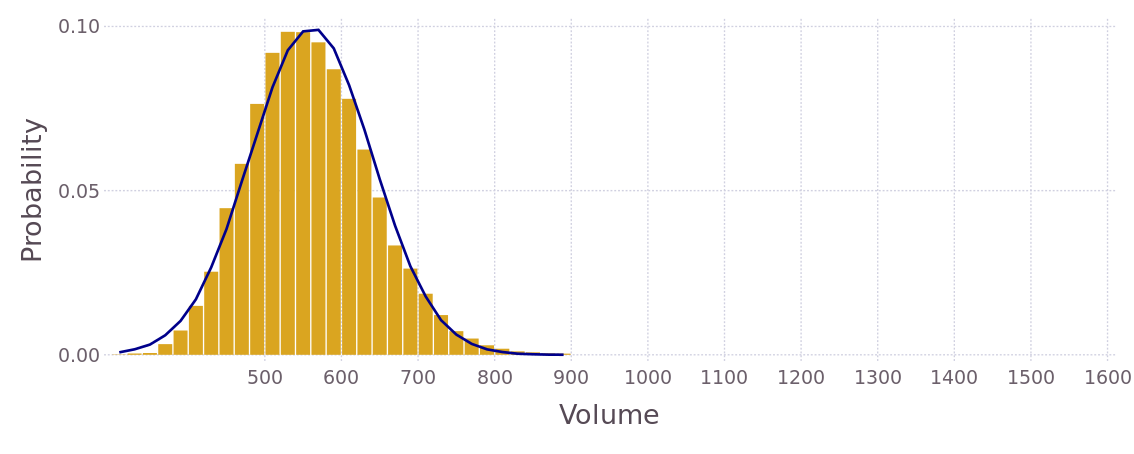

In [60]:
lyr_nor_lf = layer(df_his_nor, x = "Volume", y = "Probability",
    Geom.line,
    Theme(default_color=colorant"DarkBlue", line_width = 2pt))
lyr_vol_1ure = layer(df_Whis_vol_1ure, x = "Volume", y = "Probability",
    Geom.bar,
    Theme(bar_spacing=1pt, default_color=colorant"GoldenRod"))

pdf_Whis_vol = plot(lyr_nor_lf, lyr_vol_1ure,
    #Guide.title("Cut"),
    #Coord.cartesian(xmin = 300, xmax = 1800, ymax = 0.002),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    Guide.xticks(ticks = collect(500:100:1600)),
    
    Theme(grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

# PCA projección

#### Obtengo vectores diferencia de la trayectoria. Esto lo hago una sola vez

In [61]:
in_trj = Trajectory(joinpath(home, pdb, "pca", string("full_avgfit_", pdb, ".nc")))
nframes = convert(Int64, nsteps(in_trj))
#
# Get avg ready
#
mask = collect(7:126);
in_avg_trj = Trajectory(joinpath(home, pdb, "pca", string("full_avg_", pdb, ".pdb")))
in_avg_frm = read(in_avg_trj)
in_avg_top = Topology(in_avg_frm)
orig_aa = convert(Int64, count_residues(in_avg_top))

# Get indices de CA
orig_cas_idx = Array{Int64, 1}(orig_aa)
k = 0
for i = 0:convert(Int64, size(in_avg_top)-1)
    if name(Atom(in_avg_frm, i)) == "CA"
        k+=1
        orig_cas_idx[k] = i + 1
    end
end
cas_idx = orig_cas_idx[mask]
aa = length(cas_idx)
aa_3 = aa * 3
# Estas son las coordenadas q voy a usar p/ restar
avg_xyz = positions(in_avg_frm)[:, cas_idx];

# Ahora obtengo las proyecciones
diff_1ure = Array{Float64, 2}(aa_3, nframes)

for i = 0:nframes-1
    diff_1ure[:, i+1] = reshape(positions(read_step(in_trj, i))[:, cas_idx] .- avg_xyz, aa_3)
    if i % 1000 == 0
         println(i)
    end
end
writedlm(joinpath(rtdos, "diff_1ure"), diff_1ure)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


LoadError: [91mSystemError: opening file /home/german/labo/18/lbp/rtdos_log/diff/diff_1ure: No such file or directory[39m

#### Leo los vectores diferencia y los normalizo

In [63]:
diff_1ure = readdlm(joinpath(rtdos, "diff_1ure"))
nframes = size(diff_1ure)[2]
norm_diff_1ure = mapslices(x -> x ./ norm(x), diff_1ure, 1);

#### Obtengo las proyecciónes de vectores diferencia sobre los 1eros PCA

In [64]:
prj_1_1ure = Array{Float64, 1}(nframes)
prj_2_1ure = Array{Float64, 1}(nframes)

for i = 1:nframes
    prj_1_1ure[i] = dot(norm_diff_1ure[:, i], modes_1ure[:, 1])
    prj_2_1ure[i] = dot(norm_diff_1ure[:, i], modes_1ure[:, 2])
end

df_prj_1ure = DataFrame(PCA1 = prj_1_1ure, PCA2 = prj_2_1ure,
    Time = collect(1:length(prj_1_1ure)));

# Smooth
smooth_prj_1_1ure = [ mean(prj_1_1ure[i:i+10]) for i = 1:10:length(prj_1_1ure)-10 ]
smooth_prj_2_1ure = [ mean(prj_2_1ure[i:i+10]) for i = 1:10:length(prj_2_1ure)-10 ];

df_smooth_prj_1ure = DataFrame(PCA1 = smooth_prj_1_1ure, PCA2 = smooth_prj_2_1ure,
    Time = collect(1:length(smooth_prj_1_1ure)));

In [71]:
pdf_prj_1ure = plot(df_prj_1ure, x = "PCA1", y = "PCA2",
    #color = "Time",
    Geom.hexbin(xbincount = 80, ybincount = 40),
    #Geom.smooth(method=:loess,smoothing=0.001),
    #Guide.title("Cut"),

    #Coord.cartesian(xmin = -1., xmax = 1., ymin = -1., ymax = 1.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    Guide.xticks(ticks=collect(-1:.2:1)),
    Guide.yticks(ticks=collect(-1:.2:1)),
    
    Scale.color_continuous(colormap=Scale.lab_gradient("#f2f2f2", "Indigo", "DarkMagenta", "Black")),
    #Scale.color_continuous(minvalue = 100, maxvalue = 1000),
    #Scale.x_continuous(minvalue = 200),
    #Scale.y_continuous(minvalue = 200),
    
    Theme(bar_spacing=2pt, grid_line_width = 1pt, line_width = 2pt, point_size = 0.75pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt));

## Separo las poblaciones según PCA
##### Spoiler alert: son idénticas en volumen

In [84]:
in_bins = collect(-1:.025:1)
his_ind, his = MatHisInd2D(prj_1_1ure, prj_2_1ure, in_bins, in_bins);

msk = his .> 150
main_his = his[msk]
main_his_ind = his_ind[msk];

spy(msk[5:10, 40:55])
spy(msk[55:65, 65:73])

idx_vol0 = collect(Iterators.flatten(his_ind[5:10, 40:55]))
idx_vol1 = collect(Iterators.flatten(his_ind[55:65, 65:73]))

full_trj_vol = Array{Float64, 1}(length(trj_vol) * 10)
for i = 1:length(trj_vol)
    k = (i - 1) * 10 + 1
    full_trj_vol[k:k+9] = fill(trj_vol[i], 10)
end

trj_vol0 = full_trj_vol[idx_vol0]
trj_vol1 = full_trj_vol[idx_vol1];

In [92]:
df_full_trj_vol = DataFrame(Volume = full_trj_vol ; Time = collect(1:length(full_trj_vol)))

plot(df_full_trj_vol, x = "Time", y = "Volume",
    Geom.line,
    #Geom.smooth(method=:loess,smoothing=0.001),
    #Guide.title("Cut"),

    Geom.vline(color = "Crimson"), xintercept = idx_vol0,
    
    #Coord.cartesian(xmin = 0, xmax = 20000, ymin = 200, ymax = 1800),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt));

In [93]:
plot(df_full_trj_vol, x = "Time", y = "Volume",
    Geom.line,
    #Geom.smooth(method=:loess,smoothing=0.001),
    #Guide.title("Cut"),

    Geom.vline(color = "Crimson"), xintercept = idx_vol1,
    
    #Coord.cartesian(xmin = 0, xmax = 20000, ymin = 200, ymax = 1800),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt));

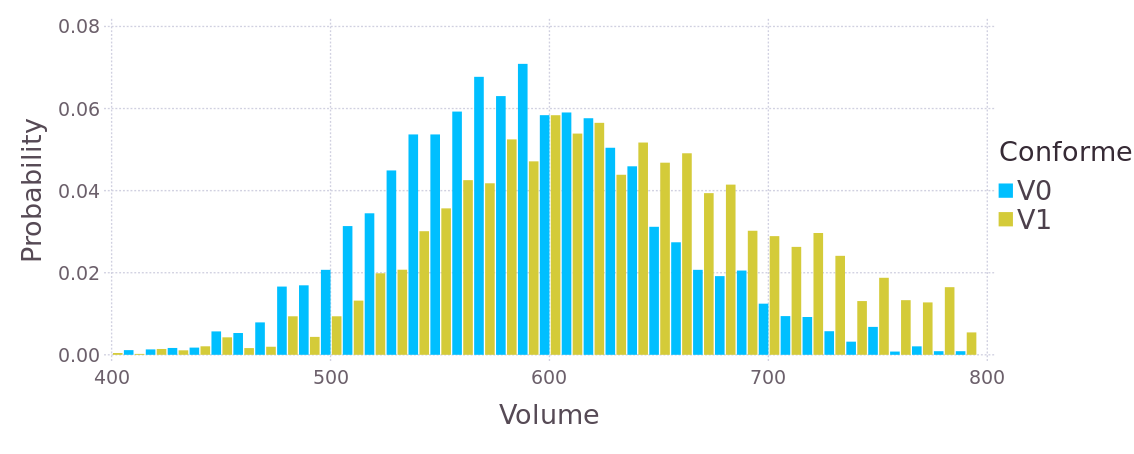

In [96]:
bin_vol = collect(400:10:800)
# Histograma ponderado
wgh_vol = fill(1.0, length(trj_vol0))
Whis_vol0_1ael, Wbins_vol0_1ael = WeightedHist(trj_vol0, bin_vol, wgh_vol, true, false);
wgh_vol = fill(1.0, length(trj_vol1))
Whis_vol1_1ael, Wbins_vol1_1ael = WeightedHist(trj_vol1, bin_vol, wgh_vol, true, false);

df_Whis_vol_str = DataFrame(Probability = [ Whis_vol0_1ael ; Whis_vol1_1ael ],
    Volume = [ Wbins_vol0_1ael ; Wbins_vol1_1ael ],
    Conformer = [ fill("V0", length(Whis_vol0_1ael)) ;
        fill("V1", length(Whis_vol1_1ael)) ]);

pdf_Whis_vol_str = plot(df_Whis_vol_str, x = "Volume", y = "Probability", color = "Conformer",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),
    #Coord.cartesian(xmin = 500, xmax = 1710),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks = collect(500:100:1700)),

    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

In [97]:
DataFrame(MEAN = [ mean(trj_vol0) ; mean(trj_vol1) ],
    STD = [ std(trj_vol0) ; std(trj_vol1) ])

2×2 DataFrames.DataFrame
│ Row │ MEAN    │ STD     │
├─────┼─────────┼─────────┤
│ 1   │ 583.803 │ 62.1458 │
│ 2   │ 641.616 │ 82.5919 │

In [98]:
# Frecuencias
car_vgmodes_1uremodes_1urev_1ure = modes_1ure * vgv_1ure
writetable(joinpath(rtdos, "freq_hist_1ure"), df_Whis_evals_1ure, separator = '\t')

# VGV cartesiano
car_vgv_1ure = modes_1ure * vgv_1ure
writedlm(joinpath(rtdos, "car_vgv_1ure"), car_vgv_1ure)

# Volumen
writetable(joinpath(rtdos, "vol_1ure"), df_trj_vol, separator = '\t')

# Histograma de volumen
writetable(joinpath(rtdos, "hist_vol_1ure"), df_Whis_vol_1ure, separator = '\t')

# Energías
writedlm(joinpath(rtdos, "energia_1ure"), E_1ure)